In [1]:
import xarray as xr
import geopandas
import regionmask

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'

# Load single instance of ERA5 grid
This is to be used with `regionmask` to create our mask

In [2]:
era5_instance = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/2t/2010/2t_era5_moda_sfc_20100101-20100131.nc')

# Load Renewable Energy Zone (REZ) boundaries

In [3]:
rez_file = '/g/data/w42/dr6273/work/data/REZ_boundaries_2021/Indicative_REZ_boundaries_2021_-_GIS_data-polygon.shp'
rez_gpd = geopandas.read_file(rez_file)

In [4]:
rez_gpd.head()

,Name,descriptio,tessellate,geometry
0,Q1 Far North QLD,REZ,1,"POLYGON ((146.13492 -17.65256, 146.09725 -17.9..."
1,Q2 North Qld Clean Energy Hub,REZ,1,"POLYGON ((143.72015 -16.97938, 143.87955 -16.9..."
2,Q3 Northern Qld,REZ,1,"POLYGON ((146.27782 -18.71920, 146.28263 -18.7..."
3,Q4 Isaac,REZ,1,"POLYGON ((147.64366 -19.94015, 147.68341 -19.9..."
4,Q5 Barcaldine,REZ,1,"POLYGON ((145.82086 -23.84279, 145.70040 -23.8..."


# Create REZ mask

In [5]:
rez_mask = regionmask.mask_3D_geopandas(
    rez_gpd,
    era5_instance.longitude,
    era5_instance.latitude,
)

In [6]:
rez_mask = rez_mask.rename({
    'latitude': 'lat',
    'longitude': 'lon'
})

### Add and sort by the region code (N1, N2, etc.)

In [7]:
rez_codes = rez_gpd['Name']
rez_codes = [i[:2] for i in rez_codes]

In [8]:
rez_mask = rez_mask.assign_coords({
    'region': rez_codes
})

In [9]:
rez_mask = rez_mask.sortby('region')

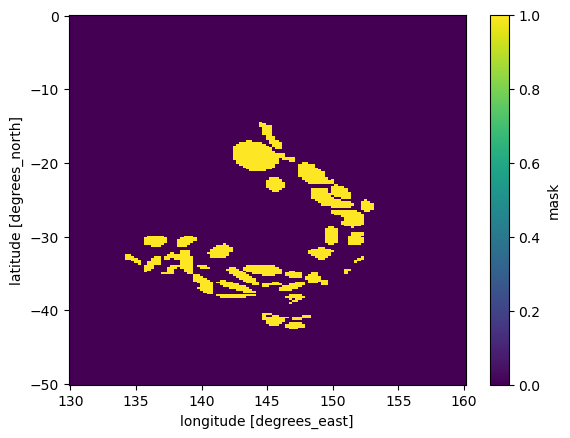

In [10]:
rez_mask.sel(
    lat=slice(0,-50),
    lon=slice(130, 160)
).sum(
    'region'
).plot()

# Renewables type coding

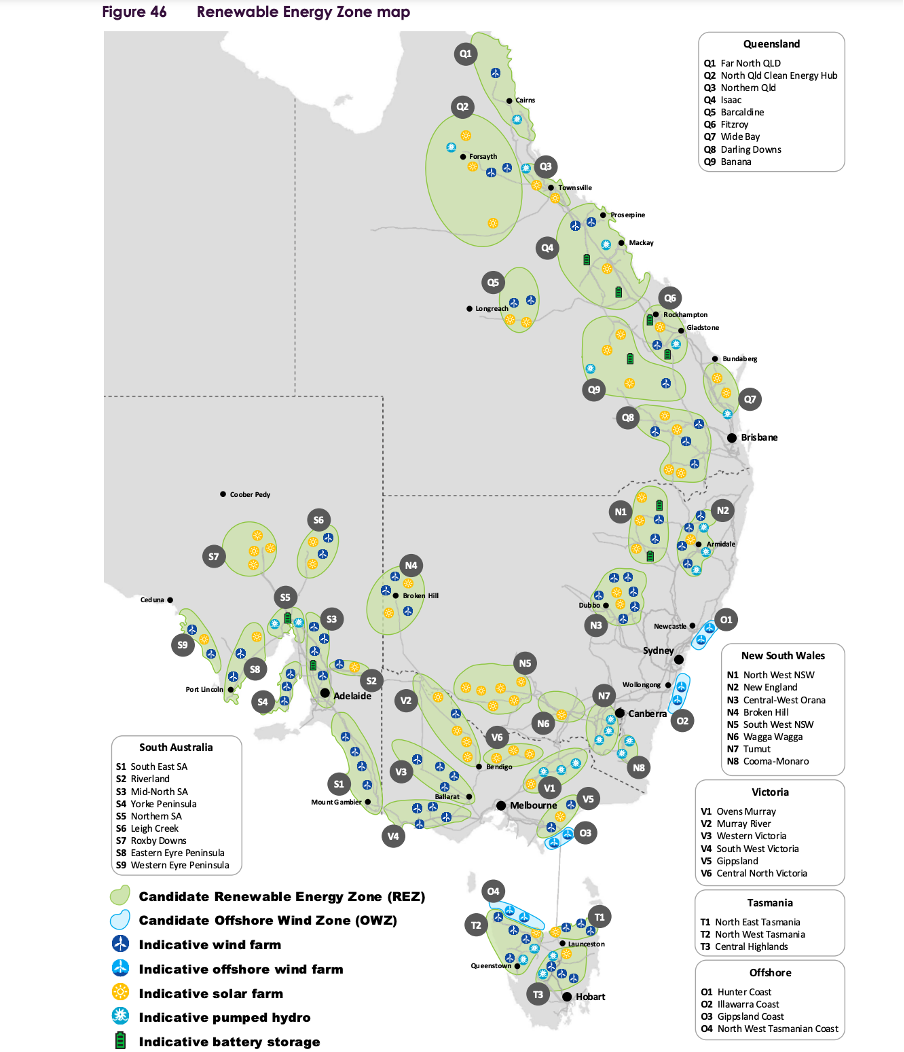

We code each region according to the type of renewables:
1. Wind
2. Solar
3. Wind and solar
4. Hydro
5. Hydro and wind
6. Hydro and solar
7. All three

Offshore is classed as wind.

In [21]:
rez_mask.region.values

array(['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'O1', 'O2', 'O3',
       'O4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'S1',
       'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'T1', 'T2', 'T3',
       'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], dtype='<U2')

In [13]:
region_codes = [
    3, 7, 3, 3, 2, 2, 4, 4,     # NSW
    1, 1, 1, 1,                 # Offshore wind
    5, 7, 6, 7, 3, 7, 6, 3, 7,  # QLD
    1, 3, 1, 1, 4, 3, 2, 3, 3,  # SA
    3, 7, 7,                    # TAS
    6, 3, 1, 1, 3, 2            # VIC
]

In [19]:
rez_mask = rez_mask.assign_coords(
    region_code=('region', region_codes)
)

# Convert to `dataset` and save

In [22]:
rez_mask_ds = rez_mask.to_dataset(name='REZ')

In [23]:
rez_mask_ds.to_netcdf('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc')